# Demixed PCA チュートリアル: 歩行ダイナミクス × メンタル状態

このノートブックでは、demixed PCA (dPCA) を使用して歩行ダイナミクスとメンタル状態の対応関係を分析する方法を学びます。

## 目次
1. 導入とセットアップ
2. データの理解
3. dPCAの理論
4. 実践: dPCAの適用
5. 結果の解釈
6. 応用例

In [2]:
# セットアップ
import sys
from pathlib import Path

# プロジェクトルートをパスに追加
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# カスタムモジュール
from src.dpca import DemixedPCA, GaitDPCA
from src.data_loader import generate_synthetic_gait_data, GaitDataLoader
from src.visualization import DPCAVisualizer

# プロット設定
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Setup complete!")

Setup complete!


## 1. データの生成と理解

まず、合成歩行データを生成します。このデータは以下の特徴を持ちます：

- **特徴量**: 関節角度（股関節、膝、足首）、体幹の動き、歩行パラメータ（歩幅、ケイデンス等）、地面反力
- **時間**: 歩行周期（0-100%）
- **条件**: メンタル状態（neutral, anxious, relaxed, focused, fatigued）

### 📊 データ変数の詳細説明

#### 歩行特徴量（Gait Features）

| 変数名 | 日本語名 | 説明 | 単位 |
|--------|----------|------|------|
| `hip_flexion` | 股関節屈曲角度 | 股関節の前後方向の角度。歩行中に脚を前に振り出す動き | 度 (°) |
| `hip_abduction` | 股関節外転角度 | 股関節の左右方向の角度。脚を横に開く動き | 度 (°) |
| `knee_flexion` | 膝関節屈曲角度 | 膝の曲げ伸ばしの角度。立脚期と遊脚期で大きく変化 | 度 (°) |
| `ankle_dorsiflexion` | 足関節背屈角度 | 足首の上下方向の角度。つま先を上げる動き | 度 (°) |
| `pelvis_tilt` | 骨盤前傾角度 | 骨盤の前後への傾き | 度 (°) |
| `pelvis_obliquity` | 骨盤傾斜角度 | 骨盤の左右への傾き | 度 (°) |
| `trunk_flexion` | 体幹屈曲角度 | 上半身の前後への傾き | 度 (°) |
| `trunk_rotation` | 体幹回旋角度 | 上半身の左右へのねじれ | 度 (°) |
| `stride_length` | 歩幅 | 同じ足の踵接地から次の踵接地までの距離 | m |
| `step_width` | 歩隔 | 左右の足の横方向の間隔 | m |
| `cadence` | ケイデンス | 1分間あたりの歩数 | steps/min |
| `grf_vertical` | 垂直地面反力 | 地面から足にかかる垂直方向の力 | N/kg |
| `grf_anterior` | 前後地面反力 | 地面から足にかかる前後方向の力（推進・制動） | N/kg |
| `grf_lateral` | 左右地面反力 | 地面から足にかかる左右方向の力 | N/kg |
| `com_velocity` | 重心速度 | 身体重心の移動速度 | m/s |

#### メンタル状態（Mental States）と歩行への影響

| 状態 | 日本語名 | 歩行への典型的な影響 |
|------|----------|---------------------|
| `neutral` | 通常状態 | 基準となる通常の歩行パターン |
| `anxious` | 不安状態 | 歩幅↓、ケイデンス↑、歩隔↓、体幹動揺↑、慎重な歩行 |
| `relaxed` | リラックス状態 | 歩幅↑、ケイデンス↓、滑らかな関節運動、自然な腕振り |
| `focused` | 集中状態 | 一定のリズム、安定した歩行パターン、効率的な動き |
| `fatigued` | 疲労状態 | 歩幅↓、関節可動域↓、地面反力の振幅↓、動作の遅延 |

#### データ構造

```
data.shape = (n_trials, n_features, n_timepoints, n_conditions)
           = (50, 15, 100, 5)

- n_trials (50): 各条件での繰り返し測定回数
- n_features (15): 上記の歩行特徴量の数
- n_timepoints (100): 歩行周期の時間点（0%=踵接地、100%=次の踵接地）
- n_conditions (5): メンタル状態の種類
```

#### 歩行周期の位相

```
0%                    60%                   100%
|------ 立脚期 -------|------ 遊脚期 -------|
踵接地  → 足底接地 → 立脚中期 → 踵離地 → 遊脚期 → 踵接地

主なイベント:
- 0%: 踵接地（Heel Strike）- 歩行周期の開始
- 0-60%: 立脚期（Stance Phase）- 足が地面についている期間
- 60-100%: 遊脚期（Swing Phase）- 足が空中にある期間
```

この合成データでは、上記のメンタル状態の影響が歩行パターンに反映されるようにシミュレートされています。

#### 📐 データの形状（4次元配列）

```
data.shape = (n_trials, n_features, n_timepoints, n_conditions)
           = (50, 15, 100, 5)
```

**視覚的なイメージ:**

```
                    条件（メンタル状態）: 5種類
                    ┌─────────────────────────────────┐
                   /│ neutral │ anxious │ relaxed │...│
                  / └─────────────────────────────────┘
                 /
時間: 100点      /    ┌─────────────────────────────────┐
(歩行周期     /     │ 0% │ 1% │ 2% │ ... │ 99% │100%│
 0-100%)    /      └─────────────────────────────────┘
           /
          /   ┌─────────────────────────────────────────┐
特徴量:  /    │ hip_flexion                             │
15個    /     │ hip_abduction                           │
       /      │ knee_flexion                            │
      /       │ ankle_dorsiflexion                      │
     /        │ pelvis_tilt                             │
    │         │ pelvis_obliquity                        │
    │         │ trunk_flexion                           │
    │         │ trunk_rotation                          │
    │         │ stride_length                           │
    │         │ step_width                              │
    │         │ cadence                                 │
    │         │ grf_vertical                            │
    │         │ grf_anterior                            │
    │         │ grf_lateral                             │
    │         │ com_velocity                            │
    │         └─────────────────────────────────────────┘
    │
トライアル: 50回（各条件で50回の繰り返し測定）
```

**各次元の意味:**

| 次元 | サイズ | 意味 | 例 |
|------|--------|------|-----|
| 0 | 50 | トライアル（繰り返し測定） | `data[0,:,:,:]` = 1回目の測定 |
| 1 | 15 | 歩行特徴量 | `data[:,0,:,:]` = 股関節屈曲角度 |
| 2 | 100 | 時間点（歩行周期 0-100%） | `data[:,:,50,:]` = 歩行周期50%時点 |
| 3 | 5 | メンタル状態 | `data[:,:,:,1]` = anxious状態 |

**データアクセスの例:**

```python
# 特定のデータにアクセス
data[10, 2, 50, 1]  # 11回目のトライアル、膝関節、歩行周期50%、anxious状態

# 特定の条件の全データ
data[:, :, :, 0]    # neutral状態の全トライアル・全特徴量・全時間点

# 特定の特徴量の時系列
data[0, 0, :, 0]    # 1回目のトライアル、股関節屈曲、全時間点、neutral状態

# トライアル平均
data.mean(axis=0)   # 形状: (15, 100, 5) - 特徴量×時間×条件
```

In [3]:
# 合成データの生成
data, metadata = generate_synthetic_gait_data(
    n_trials=50,
    n_features=15,
    n_timepoints=100,
    n_conditions=5,
    mental_state_effect_strength=0.3,
    time_effect_strength=0.5,
    interaction_strength=0.15,
    noise_level=0.1,
    random_state=42
)

print(f"データ形状: {data.shape}")
print(f"  - トライアル数: {metadata['n_trials']}")
print(f"  - 特徴量数: {metadata['n_features']}")
print(f"  - 時間点数: {metadata['n_timepoints']}")
print(f"  - 条件数: {metadata['n_conditions']}")
print(f"\n特徴量: {metadata['feature_labels']}")
print(f"\nメンタル状態: {metadata['mental_state_labels']}")

データ形状: (50, 15, 100, 5)
  - トライアル数: 50
  - 特徴量数: 15
  - 時間点数: 100
  - 条件数: 5

特徴量: ['hip_flexion', 'hip_abduction', 'knee_flexion', 'ankle_dorsiflexion', 'pelvis_tilt', 'pelvis_obliquity', 'trunk_flexion', 'trunk_rotation', 'stride_length', 'step_width', 'cadence', 'grf_vertical', 'grf_anterior', 'grf_lateral', 'com_velocity']

メンタル状態: ['neutral', 'anxious', 'relaxed', 'focused', 'fatigued']


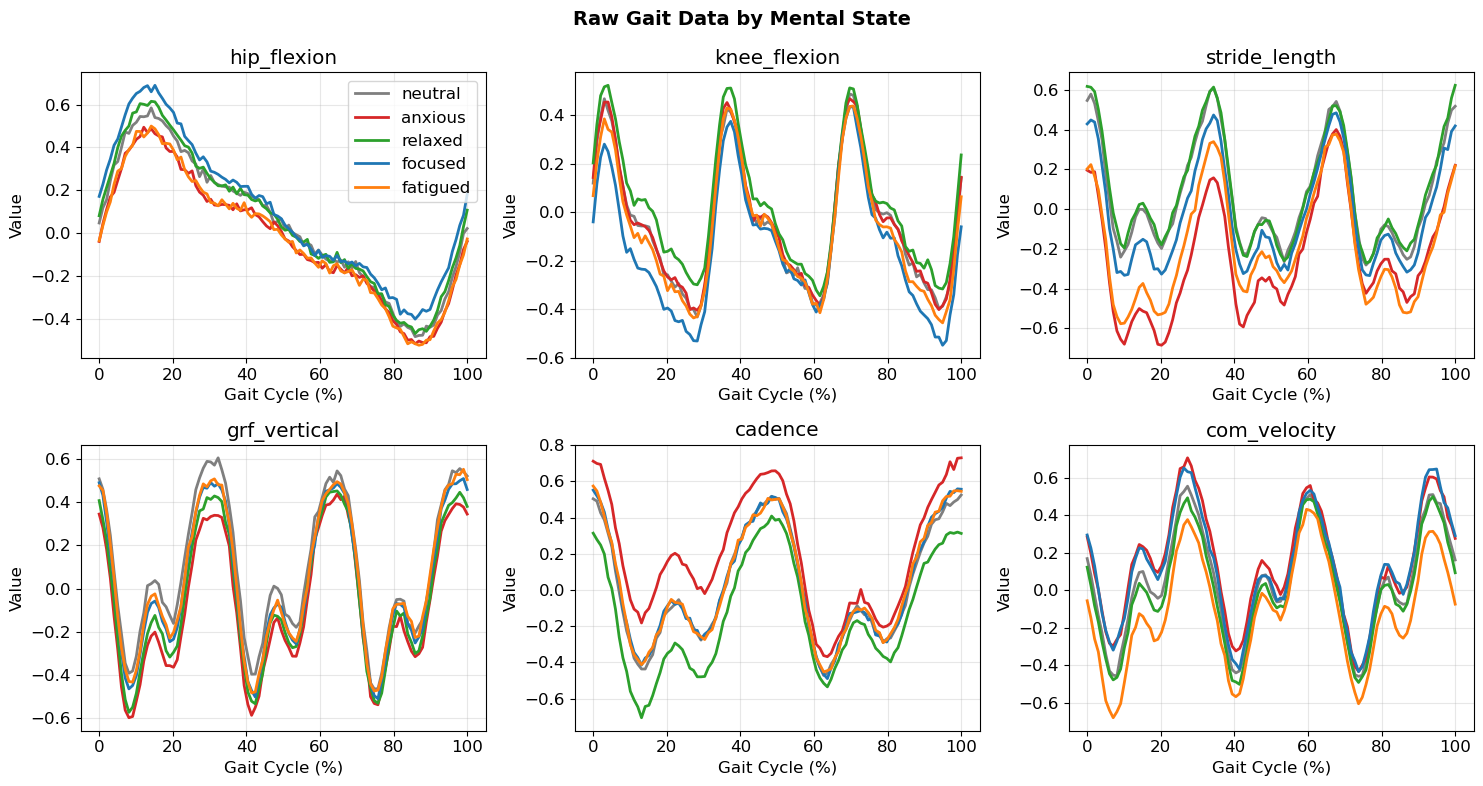

In [4]:
# データの可視化（生データ）
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

mental_states = metadata['mental_state_labels']
colors = ['#7f7f7f', '#d62728', '#2ca02c', '#1f77b4', '#ff7f0e']
time_axis = np.linspace(0, 100, 100)

# トライアル平均
data_mean = data.mean(axis=0)

feature_indices = [0, 2, 8, 11, 10, 14]  # hip, knee, stride, grf_vertical, cadence, com
feature_names = [metadata['feature_labels'][i] for i in feature_indices]

for ax, f_idx, f_name in zip(axes.flat, feature_indices, feature_names):
    for c_idx, (state, color) in enumerate(zip(mental_states, colors)):
        ax.plot(time_axis, data_mean[f_idx, :, c_idx], label=state, color=color, linewidth=2)
    ax.set_title(f_name)
    ax.set_xlabel('Gait Cycle (%)')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

axes[0, 0].legend(loc='upper right')
plt.suptitle('Raw Gait Data by Mental State', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. dPCAの理論

### Demixed PCA とは？

標準的なPCAは分散を最大化する方向を見つけますが、その成分が何を表しているかは解釈が難しいです。

**dPCA**は、データの分散を異なる「ソース」に分解します：

1. **時間成分** (Time): 歩行周期に沿った変動（条件に関係なく共通のパターン）
2. **条件成分** (Condition/Mental State): メンタル状態による変動
3. **相互作用成分** (Interaction): 時間とメンタル状態の相互作用

### 数学的定式化

データ X を以下のように分解：

$$X_{fts} = \mu_f + \text{Time}_f(t) + \text{Condition}_f(s) + \text{Interaction}_f(t, s)$$

各成分に対して、その分散を最大化しつつ全体の共分散構造を考慮した射影方向を求めます。

## 3. データの前処理

In [5]:
# データの前処理
loader = GaitDataLoader()

# 正規化とフィルタリング
data_processed = loader.preprocess(
    data,
    normalize=True,       # Z-score正規化
    filter_cutoff=0.8,    # ローパスフィルタ
    resample_points=None  # リサンプリングなし
)

# トライアル平均
data_averaged = loader.get_trial_averaged_data(data_processed)

print(f"前処理後のデータ形状: {data_averaged.shape}")
print(f"  (n_features, n_timepoints, n_conditions)")

前処理後のデータ形状: (15, 100, 5)
  (n_features, n_timepoints, n_conditions)


## 4. dPCAの適用

In [6]:
# dPCAモデルの作成とフィッティング
dpca = DemixedPCA(
    n_components=10,       # 各marginalizationで抽出する成分数
    regularizer='auto'     # 正則化パラメータを自動決定
)

# フィット
dpca.fit(
    data_averaged,
    feature_labels=metadata['feature_labels'],
    marginalization_labels=['time', 'condition', 'interaction']
)

print("モデルのフィット完了！")
print(f"正則化パラメータ: {dpca._regularizer_value:.2e}")

モデルのフィット完了！
正則化パラメータ: 1.00e-10


In [7]:
# 分散分解のサマリー
summary = dpca.get_demixing_summary()

print("\n分散分解:")
print("-" * 40)
for name, var in summary.items():
    bar = '█' * int(var * 50)
    print(f"{name:15s} | {bar:50s} | {var:.1%}")


分散分解:
----------------------------------------
time            | ███████████████████████████████████                | 70.3%
condition       | ███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 366.4%
interaction     | ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

## 5. 結果の可視化と解釈

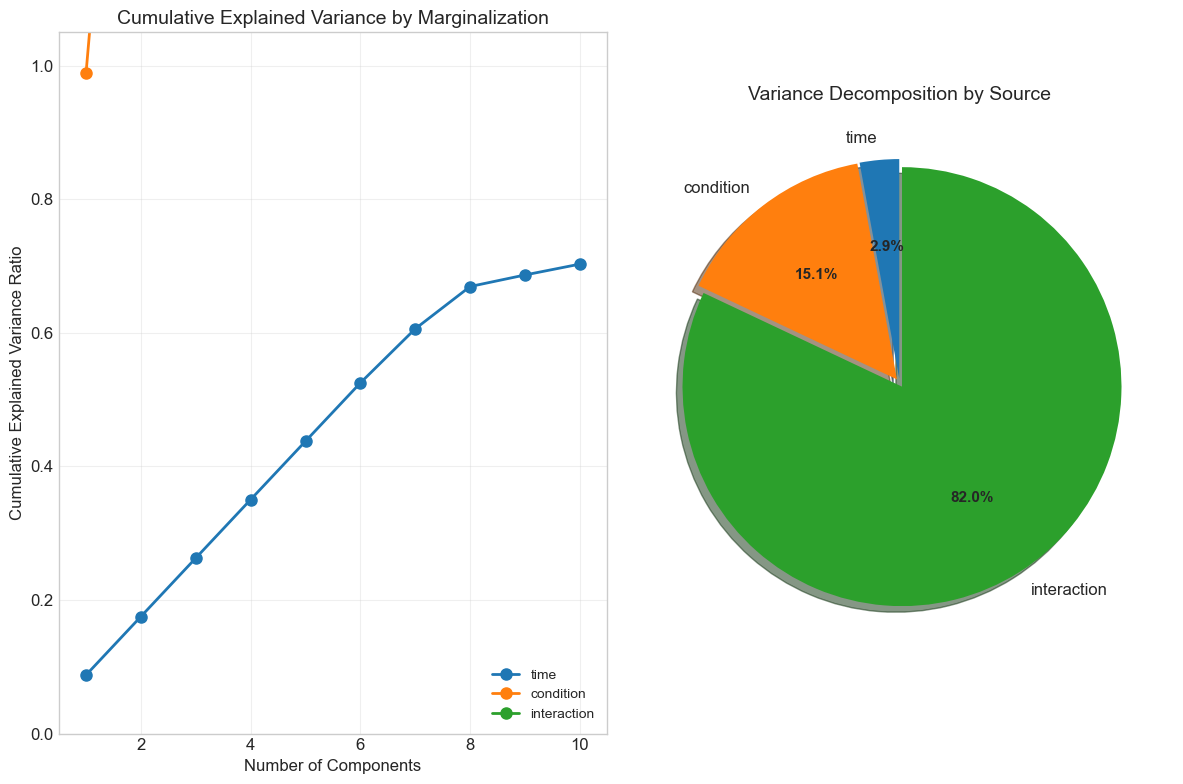

In [8]:
# 可視化オブジェクトの作成
viz = DPCAVisualizer()

# 説明分散比
fig = viz.plot_explained_variance(dpca)
plt.show()

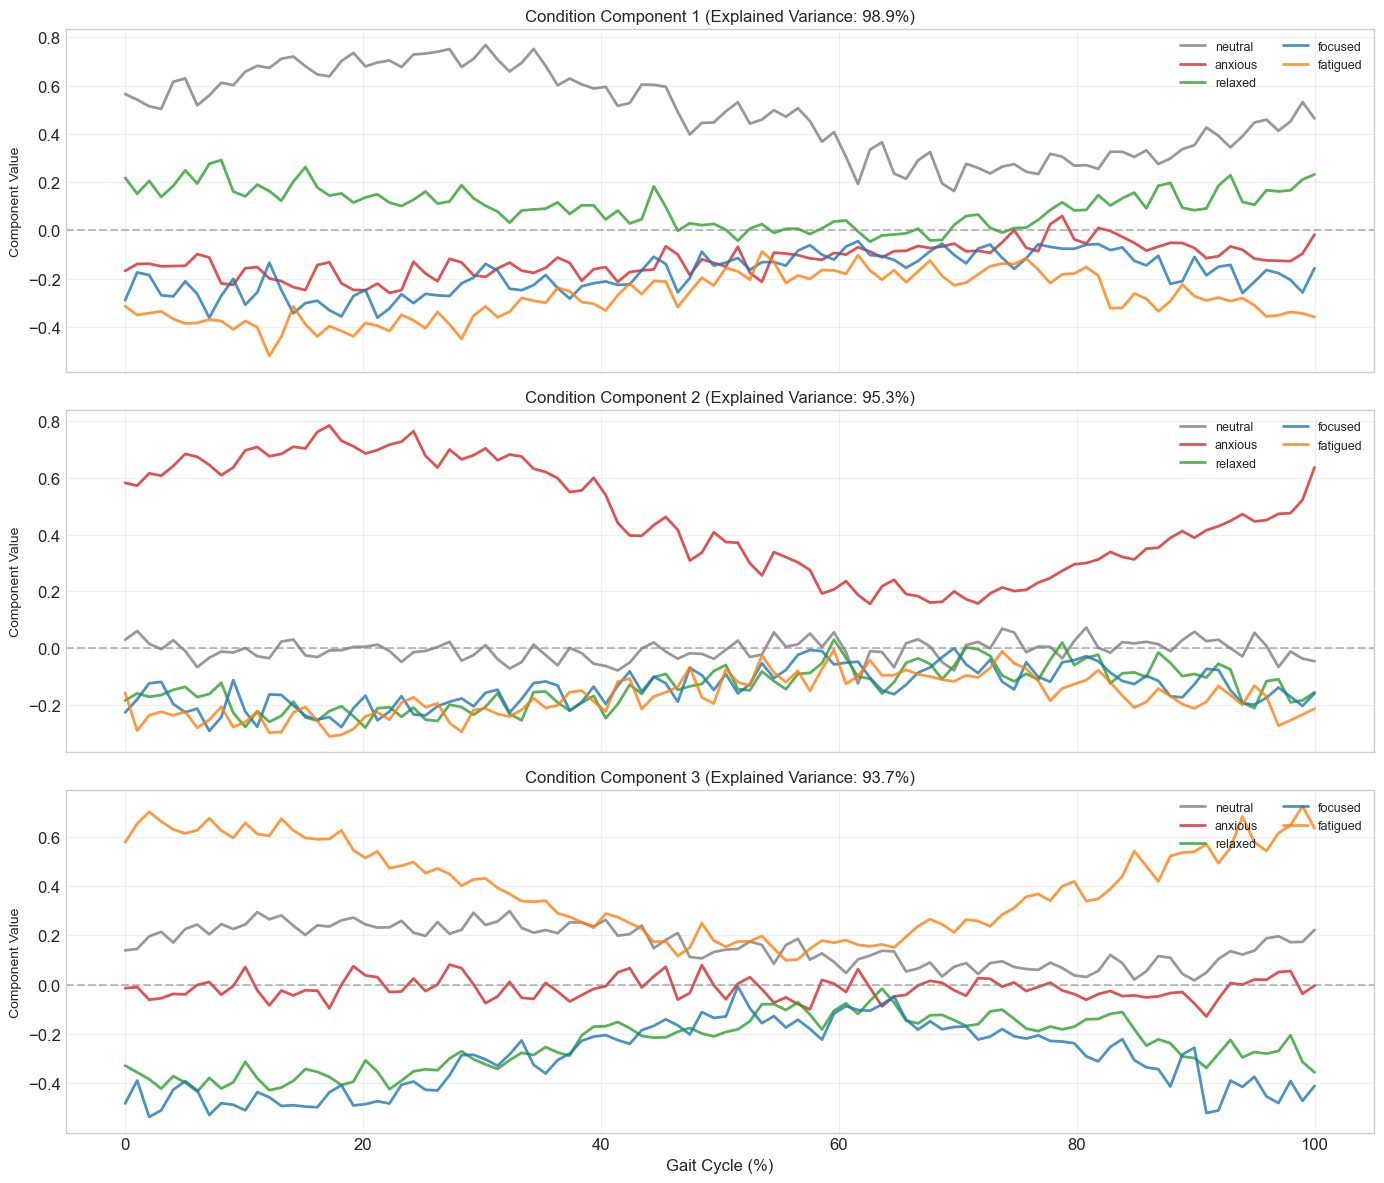

In [9]:
# 条件（メンタル状態）成分の時系列
fig = viz.plot_component_timecourse(
    dpca,
    data_averaged,
    marginalization='condition',
    components=[0, 1, 2],
    mental_state_labels=metadata['mental_state_labels']
)
plt.show()

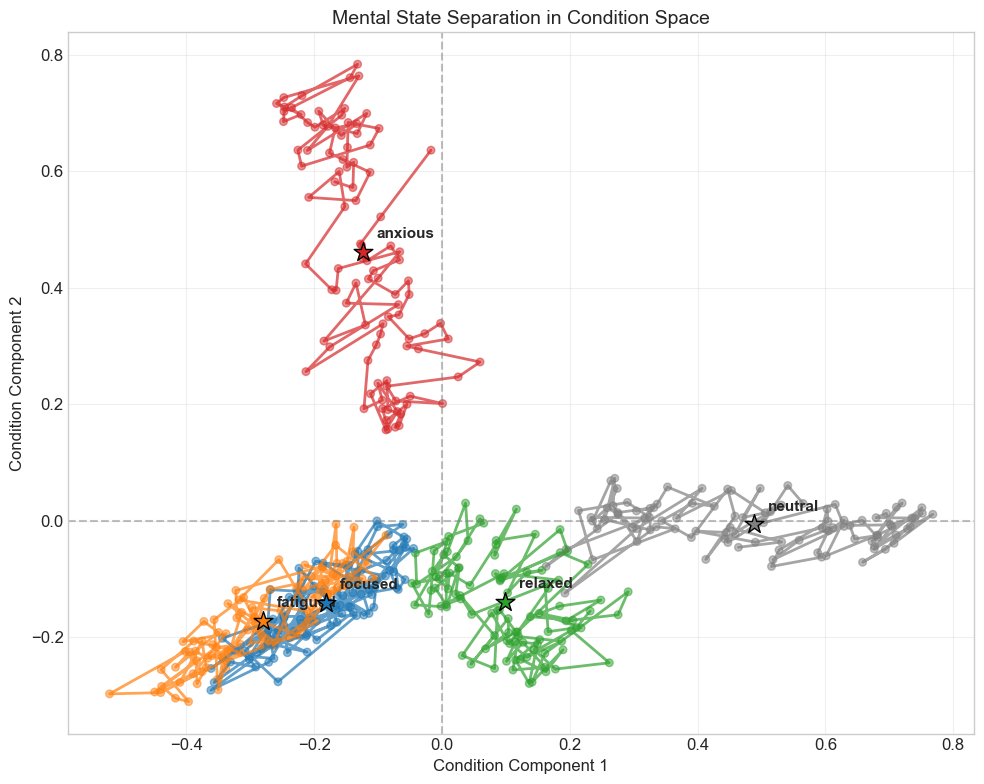

In [10]:
# メンタル状態の分離（2D射影）
fig = viz.plot_mental_state_separation(
    dpca,
    data_averaged,
    metadata['mental_state_labels'],
    marginalization='condition'
)
plt.show()

In [3]:
# 成分の重み（どの特徴量が各成分に寄与しているか）
fig = viz.plot_component_weights(
    dpca,
    marginalization='condition',
    component=0,
    feature_labels=metadata['feature_labels']
)
plt.show()

NameError: name 'viz' is not defined

In [ ]:
# 包括的なサマリープロット
fig = viz.plot_comprehensive_summary(
    dpca,
    data_averaged,
    metadata['mental_state_labels'],
    metadata['feature_labels']
)
plt.show()

## 6. メンタル状態の分離度分析

In [ ]:
# GaitDPCAを使用した分離度分析
gait_dpca = GaitDPCA(n_components=10)
gait_dpca.fit_with_labels(
    data_averaged,
    mental_state_labels=metadata['mental_state_labels'],
    feature_labels=metadata['feature_labels']
)

# メンタル状態間の分離度を計算
separation_scores = gait_dpca.analyze_mental_state_separation(
    data_averaged,
    metadata['mental_state_labels']
)

print("\nメンタル状態間の分離度スコア:")
print("-" * 50)
sorted_scores = sorted(separation_scores.items(), key=lambda x: x[1], reverse=True)
for pair, score in sorted_scores:
    bar = '█' * int(score * 10)
    print(f"{pair:25s} | {bar:20s} | {score:.3f}")

In [ ]:
# 分離度をヒートマップで可視化
states = metadata['mental_state_labels']
n_states = len(states)
separation_matrix = np.zeros((n_states, n_states))

for pair, score in separation_scores.items():
    s1, s2 = pair.split('_vs_')
    i, j = states.index(s1), states.index(s2)
    separation_matrix[i, j] = score
    separation_matrix[j, i] = score

plt.figure(figsize=(8, 6))
sns.heatmap(
    separation_matrix,
    xticklabels=states,
    yticklabels=states,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=np.median(separation_matrix)
)
plt.title('Mental State Separation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

## 7. まとめ

このチュートリアルでは、dPCAを使用して歩行ダイナミクスとメンタル状態の関係を分析しました。

### 主な発見:

1. **時間成分**: 歩行周期に沿った主要な運動パターンを捉えています
2. **条件成分**: メンタル状態による歩行の変化を反映しています
3. **相互作用成分**: メンタル状態によって歩行パターンの形状が変化する様子を示しています

### 応用:

- メンタルヘルスモニタリング
- 歩行リハビリテーション
- スポーツパフォーマンス分析
- 神経変性疾患の早期発見